In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from fastai.text import *

In [6]:
df = pd.read_csv('/code/17_742210_bundle_archive/Tweets.csv', low_memory=False)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
print(df.isnull().sum())
pos_sum = df[df['airline_sentiment']=='positive']
neu_sum = df[df['airline_sentiment']=='neutral']
neg_sum = df[df['airline_sentiment']=='negative']
zero_sum = df[df['negativereason_confidence']==0]
print('------------------------------------------------------')
print('total_non_neg = ',len(pos_sum)+len(neu_sum))
print('total zeros in neg_confidence = ',len(zero_sum))
print('------------------------------------------------------')
print('total_rows = ',len(pos_sum)+len(neu_sum)+len(neg_sum))

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
------------------------------------------------------
total_non_neg =  5462
total zeros in neg_confidence =  1344
------------------------------------------------------
total_rows =  14640


In [8]:
df_new = df.drop(['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'], axis=1)
df_new.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
path = '/code/17_742210_bundle_archive/'

In [11]:
data_lm = (TextList
           .from_csv(path, 'Tweets.csv', cols='text')
           #Where are the text? Column 'text' of tweets.csv
           .split_by_rand_pct(0.2)
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(bs=48))
           #Finally we convert to a DataBunch
data_lm.show_batch()   

idx,text
0,"about it xxbos @virginamerica seriously would pay $ 30 a flight for seats that did n't have this playing . \n it 's really the only bad thing about flying xxup va xxbos @virginamerica yes , nearly every time i fly xxup vx this “ xxunk xxunk ” wo n’t go away :) xxbos @virginamerica xxmaj really missed a prime opportunity for xxmaj men xxmaj without xxmaj hats xxunk"
1,service to xxmaj hawaii from # xxunk this year http : / / t.co / xxunk # xxunk xxbos @virginamerica xxmaj other carriers are less than half price for a round trip fare . i am xxunk . http : / / t.co / xxunk xxbos @virginamerica xxup wtf is happening in xxup pdx xxmaj late xxmaj flight xxmaj march such that one way from xxup sfo is xxunk ?
2,"a one time thing either ! xxmaj it 's a shocking xxunk of xxunk neglect and disrespect . xxbos @united xxmaj fingers crossed & & its all xxunk . xxmaj very disappointed with this experience as before this we were actually saying we enjoyed using you xxbos @united xxmaj it 's an incredibly easy fix , but you would rather stay in your comfort zone , while i get forced"
3,"fucked up , then xxunk my ticket , and xxup kept xxup my xxup money . xxmaj not even an apology . i will never fly with your airline again . # unitedairlines xxbos @united has the xxup worst customer xxunk ! xxmaj this xxmaj xxunk rep at call center must be investigated . xxmaj my baggage 's lost and there 's no help but argument ! xxbos @united should"
4,"- xxup 400er on xxup xxunk # avgeek xxbos @united has the best customer experience via twitter - huge fan ! ! ! xxbos @united xxmaj beyond frustrated xxmaj xxunk change = no seats , earlier departure and double layover . xxmaj of course only seats are $ $ + + . xxmaj cust svc no help xxbos @united working with xxmaj lisa j at xxup ord . she 's"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


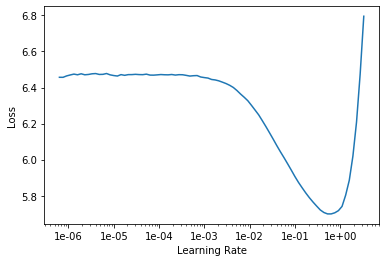

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(6, 5e-2, moms=(0.85, 0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.474607,3.894004,0.262202,02:05
1,4.045689,3.922657,0.259889,02:06
2,3.799794,3.872575,0.268939,02:04
3,3.543330,3.819221,0.276312,02:04
4,3.257934,3.786902,0.283874,02:05
5,3.038205,3.784923,0.284821,02:04


In [14]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.992616,3.799198,0.286878,03:46
1,3.079972,3.814297,0.282102,03:46
2,3.129158,3.837992,0.279437,03:45
3,2.982880,3.895209,0.278801,03:45
4,2.711163,3.965303,0.280330,03:46
5,2.333162,4.087592,0.282481,03:46
6,1.823585,4.301482,0.281101,03:45
7,1.349901,4.509263,0.279978,03:45
8,1.020861,4.643915,0.281182,03:46
9,0.881835,4.675747,0.281007,03:46


In [15]:
TEXT = "The flight got delayed"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
#Save fine-tuned model for future use
learn.save_encoder('fine_tuned_enc')

The flight got delayed 2 hours ! NO OPTIONS ! RT @jetblue : Our fleet 's on fleek . http : / / t.co / guess xxbos @americanair Thanks for sharing . i send you my info to let
The flight got delayed 1 hour because of @jetblue xxbos @united So you 're going to charge us $ 100 bucks ! ! # badcustomerservice xxbos @united just curious , when are you going to to finally learn # customerservice ? xxbos @usairways


In [27]:
data_clas = (TextList.from_csv(path, 'Tweets.csv', cols='text')
             #Where are the text? Column 'text' of tweets.csv
             .split_by_rand_pct(0.2)
             #How to split it? Randomly with the default 20% in valid
             .label_from_df(cols='airline_sentiment')
             #specify the label column
             .databunch(bs=48))
             #Create databunch
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,negative
xxbos @usairways xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,negative
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj xxunk , reflight xxmaj booking xxmaj xxunk , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # xxunk # xxunk # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxmaj help 😍 \n 💗 🇬 🇧 💗 🇺 🇸 💗 \n 🎀 xxunk 🎀 http : / / t.co / xxunk,neutral


In [29]:
data_clas.vocab.itos = data_lm.vocab.itos
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos flightled xxmaj what xxunk better .,xxbos flightled few you today unhelpful 😍 to the problems ... xxunk .,xxbos flightled i please n't like ... xxmaj happens happened i delayed to want take before !,xxbos flightled and @southwestair at a people taking passengers three bag @southwestair,xxbos flightled than , turned business time i more xxup bill this since xxunk xxunk said some appreciated going things :)
y: CategoryList
neutral,positive,neutral,negative,positive
Path: /code/17_742210_bundle_archive;

Valid: LabelList (2928 items)
x: TextList
xxbos is 5 the early , then the wednesday ...,xxbos is flight xxunk i delayed 2 assistance on the 5 flight customer t xxup extremely 2 xxup .@usairways . i 'm y' frankfurt . i today been no this way for xxunk right .,xxbos @united xxup xxunk am now call asap open poor min . xxmaj wow . xxmaj make up that program .,xxbos @usairways that terrible was an xxunk finall

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


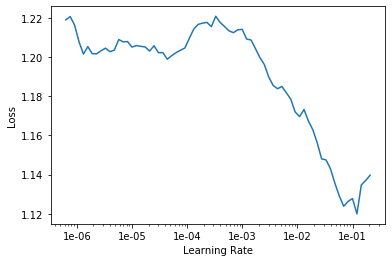

In [30]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [31]:
learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.899321,0.824289,0.662910,01:20
1,0.878739,0.802433,0.693989,01:20
2,0.791511,0.861139,0.699112,01:20
3,0.830247,0.764425,0.704576,01:20


In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.767992,1.260159,0.704235,01:41
1,0.737490,0.934060,0.722678,01:39
2,0.749074,0.704764,0.732582,01:39
3,0.713803,0.745865,0.728825,01:40


In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.703263,0.797022,0.747951,03:00
1,0.625732,0.578014,0.768784,03:00
2,0.557778,0.564941,0.784836,03:02
3,0.516304,0.573058,0.779030,03:02


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


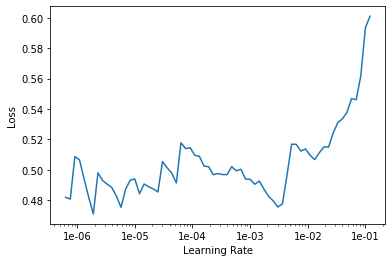

In [34]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [35]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('fwd_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.464878,0.567362,0.781079,04:16
1,0.479219,0.583479,0.783811,04:16
2,0.467827,0.575658,0.783811,04:16
3,0.441684,0.572710,0.785178,04:17
4,0.409565,0.588106,0.781079,04:16


In [36]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)
accuracy(pred_fwd, lbl_fwd)

tensor(0.7811)

In [43]:
learn.predict("Vistara Airways is unpredictably bad.")

(Category tensor(1), tensor(1), tensor([0.1334, 0.7422, 0.1244]))